In [0]:
! pip install catboost

from catboost import CatBoostRegressor, Pool, cv

In [0]:
import pandas as pd
import zipfile as z
import re
from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain
from functools import reduce
import re
import pickle
import os
import datetime
import seaborn as sns
import datetime
from tensorflow.python.client import timeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy import stats
from scipy.stats import boxcox

from warnings import filterwarnings
filterwarnings('ignore')


import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
DIR2MAPS = './gdrive/My Drive/maps_from_cat2index'
DIR2MAPS_BL = './gdrive/My Drive/maps_from_cat2index_bl'
EMBEDS_DIR = './gdrive/My Drive/embeddings_nn'
MEAN_STD_TUPLE_DIR = './gdrive/My Drive/mean_std.pickle'
DIR2Q = './gdrive/My Drive/q_list.pickle'
DIR2EMBS_SHAPE = './gdrive/My Drive/var_e_shapes.pickle'
DIR2WORD2ID = './gdrive/My Drive/word2id.pickle'
PATH2W2VEMBEDDINGS = './gdrive/My Drive/'
PRETRAINED_W_DIR = './gdrive/My Drive'

In [0]:
CURR_DF_NM = 'data_train_3.csv'

### Feature discription

In [0]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273971 entries, 0 to 1273970
Data columns (total 43 columns):
eventID                                   1273971 non-null int64
case Spend area text                      1260926 non-null object
case Company                              1273971 non-null object
case Document Type                        1273971 non-null object
case Sub spend area text                  1260926 non-null object
case Purchasing Document                  1273971 non-null int64
case Vendor                               1273971 non-null object
case Item Type                            1273971 non-null object
case Item Category                        1273971 non-null object
case Spend classification text            1260926 non-null object
case Name                                 1273971 non-null object
case GR-Based Inv. Verif.                 1273971 non-null bool
case Item                                 1273971 non-null int64
case concept:name                 

In [0]:
"""
FEATURES
----------
1. eventID - default                                          || Event index
2. case Spend area text - default                             || A text explaining the area for the purchase item
3. case Company - default                                     || Anonymized company
4. case Document Type - default                               || Document type (text)
5. case Sub spend area text - default                         || Another text explaining the area for the purchase item
6. case Purchasing Document - default                         || The anonymized purchasing document ID

7. case Purch. Doc. Category name - default                   || The name of the category of the purchasing document (text) 
                                                              || (1 dist value) - REMOVED

8. case Vendor - default                                      || Anonymized vendor
9. case Item Type - default                                   || Type of the item (text)
10. case Item Category - default                              || Item category (text)
11. case Spend classification text - default                  || A text explaining the class of purchase item

12. case Source - default                                     || Anonymized source system of item 
                                                              || (1 dist value) - REMOVED

13. case Name - default                                       || Anonymized name of vendor
14. case GR-Based Inv. Verif. - default                       || Bool
15. case Item - default                                       || Anonymized item ID
16. case concept:name - default                               || Key for case
17. case Goods Receipt - default                              || Bool
18. event User - default                                      || Anonymized user
19. event org:resource - default                              || Anonymized resource
20. event concept:name - default                              || Text description of event
21. event Cumulative net worth (EUR) - default                || Cost of activity (event)
-------------------------------------------------
22. start_time_timestamp - timestamp from original timestamp,
                           stored as pd timestamp
23. target - longevity of a case in days (0.5 days is equal to 0 in target),
             stored as int
24. time_after_pr_event_in_case - time difference in days between current event
                                  and previous event (but if previous event has
                                  the same timestamp we take another previous event
                                  with different timestamp),
                                  stored in int
25. ema_on_time_bet_events - ema on time difference between events,
                             stored in float
26. month_event - month of the event,
                  stored in int
27. day_event - calendar day of the event,
                stored in int
28. week_day_event - week day of the event,
                      stored in int
29-43. case_spend_area_text_encoded, case_company_encoded, case_document_type_encoded,
       case_sub_spend_area_text_encoded, case_purchasing_document_encoded, case_vendor_encoded,
       case_item_type_encoded, case_item_category_encoded, case_spend_classification_text_encoded,
       case_name_encoded, case_gr-based_inv._verif._encoded, case_goods_receipt_encoded,
       event_user_encoded, event_org:resource_encoded, event_concept:name_encoded ---- 
       ----------- order encoding of the corresponding categorical features (maps are stored on the disk with unk token)

44. ema_on_net_worth - ema on cmulative net worth (stored in float)

45. gr_inv_gr_cat - category of purchase according mentioned in the doc categorisation
                    (stored in int)
"""

### Mount drive

In [0]:
from google.colab import drive
drive.mount('./gdrive', force_remount= True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


#### Current dataframe import

In [0]:
data_train = pd.read_csv(os.path.join('./gdrive/My Drive', CURR_DF_NM), 
                         dtype = {'start_time_timestamp': 'str'}, 
                         parse_dates= ['start_time_timestamp'])

### Import data and prepare csv file

In [0]:
!wget 'http://icpmconference.org/2019/wp-content/uploads/sites/6/2019/02/BPIChallenge2019CSV.zip'

--2019-11-28 07:53:08--  http://icpmconference.org/2019/wp-content/uploads/sites/6/2019/02/BPIChallenge2019CSV.zip
Resolving icpmconference.org (icpmconference.org)... 37.128.148.44
Connecting to icpmconference.org (icpmconference.org)|37.128.148.44|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://icpmconference.org/2019/wp-content/uploads/sites/6/2019/02/BPIChallenge2019CSV.zip [following]
--2019-11-28 07:53:09--  https://icpmconference.org/2019/wp-content/uploads/sites/6/2019/02/BPIChallenge2019CSV.zip
Connecting to icpmconference.org (icpmconference.org)|37.128.148.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36720297 (35M) [application/zip]
Saving to: ‘BPIChallenge2019CSV.zip’

BPIChallenge2019CSV 100%[===================>]  35.02M  9.95MB/s    in 5.5s    

2019-11-28 07:53:16 (6.32 MB/s) - ‘BPIChallenge2019CSV.zip’ saved [36720297/36720297]



In [0]:
data_zip = z.ZipFile('/content/BPIChallenge2019CSV.zip')

In [0]:
data_zip.extractall()

In [0]:
def gen():
  with open('/content/BPI_Challenge_2019.csv', encoding = 'latin') as file:
    for line in file:
      yield line

In [0]:
with open('/content/file.csv', 'w') as gile:
  for line in tqdm(gen()):
    line_ = re.sub(r'(?<=[A-Za-z]),(?= )', ' ', line)
    gile.write(line_)

1595924it [00:21, 75447.97it/s]


In [0]:
data = pd.read_csv('/content/file.csv')

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595923 entries, 0 to 1595922
Data columns (total 22 columns):
eventID                             1595923 non-null int64
case Spend area text                1579629 non-null object
case Company                        1595923 non-null object
case Document Type                  1595923 non-null object
case Sub spend area text            1579629 non-null object
case Purchasing Document            1595923 non-null int64
case Purch. Doc. Category name      1595923 non-null object
case Vendor                         1595923 non-null object
case Item Type                      1595923 non-null object
case Item Category                  1595923 non-null object
case Spend classification text      1579629 non-null object
case Source                         1595923 non-null object
case Name                           1595923 non-null object
case GR-Based Inv. Verif.           1595923 non-null bool
case Item                           1595923 non-nul

In [0]:
data.head().T

,0,1,2,3,4
eventID,65781719105536,65777424138241,65777424138240,65794604007424,65794604007425
case Spend area text,Sales,Sales,Sales,Sales,Sales
case Company,companyID_0000,companyID_0000,companyID_0000,companyID_0000,companyID_0000
case Document Type,Standard PO,Standard PO,Standard PO,Standard PO,Standard PO
case Sub spend area text,Products for Resale,Products for Resale,Products for Resale,Products for Resale,Products for Resale
case Purchasing Document,4507004931,4507004931,4507004931,4507004931,4507004931
case Purch. Doc. Category name,Purchase order,Purchase order,Purchase order,Purchase order,Purchase order
case Vendor,vendorID_0670,vendorID_0670,vendorID_0670,vendorID_0670,vendorID_0670
case Item Type,Standard,Standard,Standard,Standard,Standard
case Item Category,3-way match invoice before GR,3-way match invoice before GR,3-way match invoice before GR,3-way match invoice before GR,3-way match invoice before GR


### Train Test Split

In [0]:
cases_train, cases_test = train_test_split(data['case concept:name'].unique(), test_size = 0.2, random_state = 0)

In [0]:
data_train, data_test = data.loc[data['case concept:name'].isin(cases_train), :], data.loc[data['case concept:name'].isin(cases_test), :]

In [0]:
data_test.to_csv('./gdrive/My Drive/data_test.csv', index = False)

In [0]:
print('train shape {s}\ntest shape {t}'.format(s = data_train.shape, t = data_test.shape))

train shape (1273971, 22)
test shape (321952, 22)


### Time based features

#### Design target

In [0]:
class targetDesigner(object):
  def __init__(self, data):
    self.data = data

  def _gen(self, cases):
    for i in self.data['case concept:name'].unique():
      yield i, cases.get_group(i)

  def _get_cases(self):
    return self.data.groupby(by = 'case concept:name')

  def _transform_timestamp(self):
    self.data['start_time_timestamp'] = self.data['event time:timestamp'].apply(lambda x: \
                          datetime.datetime.strptime(x, '%d-%m-%Y %H:%M:%S.%f'))
    self.data.drop('event time:timestamp', axis =1, inplace = True)
    return self
  
  def construct_target(self):
    cases = (self
     ._transform_timestamp()
     ._get_cases())
    
    self.case2target = {}

    g = self._gen(cases)

    for key, case in tqdm(g):
      dates = case.start_time_timestamp
      dates = sorted(dates)
      start_date, finish_date = dates[0], dates[-1]
      delta = finish_date - start_date
      self.case2target[key] = delta.days
    return self
  
  def return_transformed_data(self):
    self.data['target'] = self.data['case concept:name'].apply(lambda x: self.case2target[x])
    return self.data


In [0]:
t_D = targetDesigner(data_train)
data_train = (t_D
              .construct_target()
              .return_transformed_data())

201387it [03:15, 1031.55it/s]


#### Add another time features

##### Time from previous event

In [0]:
class TimeFromPrEvent(object):
  def  __init__(self, data):
    self.data = data

  def _groupCases(self):
    self.cases = self.data.groupby('case concept:name')

  def _gen(self):
    for i in self.data['case concept:name'].unique():
      yield i, self.cases.get_group(i)

  def makeVocab(self):
    self.event2diff = {}

    self._groupCases()
    g = self._gen()

    for _, case in tqdm(g):
      case.sort_values(by = 'start_time_timestamp', inplace = True)
      indexes = case.index
      dates = case.start_time_timestamp
      min_last_date = dates[indexes[0]]
      self.event2diff[indexes[0]] = 0

      for index, pr_date, n_date in zip(indexes[1:], dates[:-1], dates[1:]):
        if pr_date.date() == n_date.date():
          pr_date = min_last_date
          self.event2diff[index] = (n_date.date() - pr_date.date()).days
        else:
          self.event2diff[index] = (n_date.date() - pr_date.date()).days
          min_last_date = pr_date
    return self
  
  def updateData(self):
    self.data['index'] = self.data.index 
    self.data['time_after_pr_event_in_case'] = self.data['index'].apply(lambda x: self.event2diff[x])
    return self.data.drop('index', axis = 1)

  def constructEMA(self):
    self.eventid2ema = {}


    g = self._gen()
    alpha = 0.1

    for _, case in tqdm(g):
      case.sort_values(by = 'start_time_timestamp', inplace = True)
      e_ids, diffs = case['eventID '].values, case.time_after_pr_event_in_case.values

      self.eventid2ema[e_ids[0]] = diffs[0]
      pr_ema = diffs[0]

      for e_id, diff in zip(e_ids[1:], diffs[1:]):
        current_ema = alpha * diff + (1 - alpha) * pr_ema
        pr_ema = current_ema
        self.eventid2ema[e_id] = current_ema

    return self

  def updateDataEma(self):
    self.data['ema_on_time_bet_events'] = self.data['eventID '].apply(lambda x: self.eventid2ema[x])
    return self.data

In [0]:
d = TimeFromPrEvent(test_data)
test_data = (d
             .makeVocab()
             .updateData())

##### EMA on time between events in case

In [0]:
eventid2ema = {}

g = gen()
alpha = 0.1

for _, case in tqdm(g):
  case.sort_values(by = 'start_time_timestamp', inplace = True)
  e_ids, diffs = case['eventID '].values, case.time_after_pr_event_in_case.values

  eventid2ema[e_ids[0]] = diffs[0]
  pr_ema = diffs[0]

  for e_id, diff in zip(e_ids[1:], diffs[1:]):
    current_ema = alpha * diff + (1 - alpha) * pr_ema
    pr_ema = current_ema
    eventid2ema[e_id] = current_ema

In [0]:
data_train['ema_on_time_bet_events'] = data_train['eventID '].apply(lambda x: eventid2ema[x])

In [0]:
cases = data_train.groupby('case concept:name')
cases.groups

In [0]:
key = '2000052847_00003'

group = cases.get_group(key)

In [0]:
group.sort_values(by = 'start_time_timestamp', inplace = True)
diffs, emas = group.time_after_pr_event_in_case.values, group.ema_on_time_bet_events.values

Text(0.5, 1.0, 'ema and diffs on time between events')

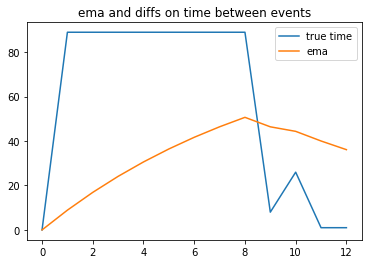

In [0]:
plt.plot(range(len(diffs)), diffs, label = 'true time')
plt.plot(range(len(diffs)), emas, label = 'ema')
plt.legend()
plt.title('ema and diffs on time between events')

##### Add month, day, weekday

In [0]:
data_train['month_event'] = data_train.start_time_timestamp.apply(lambda x: x.month)

In [0]:
data_train['day_event'] = data_train.start_time_timestamp.apply(lambda x: x.day)

In [0]:
data_train['week_day_event'] = data_train.start_time_timestamp.apply(lambda x: x.weekday())

### Remove features with one distinct value

In [0]:
feats = ['case Spend area text', 'case Company', 'case Document Type', 'case Sub spend area text',
         'case Purchasing Document', 'case Purch. Doc. Category name', 'case Vendor', 'case Item Type',
         'case Item Category', 'case Spend classification text', 'case Source', 'case Name', 
         'case Item', 'event User', 'event org:resource', 'event concept:name']

for feat in feats:
  print('{f} - {n}'.format(f = feat, n = len(data_train[feat].unique())))

In [0]:
data_train.drop(['case Purch. Doc. Category name', 'case Source'], axis = 1, inplace = True)

### Encoding categorical variables

In [0]:
cat_feats = ['case Spend area text', 'case Company', 'case Document Type', 'case Sub spend area text',
             'case Purchasing Document', 'case Vendor', 'case Item Type', 'case Item Category',
             'case Spend classification text', 'case Name', 'case GR-Based Inv. Verif.',
             'case Goods Receipt', 'event User', 'event org:resource', 'event concept:name']

In [0]:
for feat in tqdm(cat_feats):
  feat2index = {val: index + 1 for index, val in enumerate(data_train[feat].unique())}
  feat2index['unk'] = 0

  feat_ = '_'.join(feat.lower().split()) + '_encoded'
  data_train[feat_] = data_train[feat].apply(lambda x: feat2index[x])
  with open(os.path.join(DIR2MAPS, feat_ + '_map.pickle'), 'wb') as file:
    pickle.dump(feat2index, file)

### Build baseline

#### Prepare features

In [0]:
######## features for baseline

real_features_baseline = ['event Cumulative net worth (EUR)', 'case GR-Based Inv. Verif.', 'case Goods Receipt']
cat_features_baseline = ['case Spend area text', 'case Company',
       'case Document Type', 'case Sub spend area text',
       'case Purchasing Document', 'case Vendor', 'case Item Type',
       'case Item Category', 'case Spend classification text', 'case Name',
       'case Item', 'event User', 'event org:resource', 'event concept:name']
target_feature = ['target']

In [0]:
######### data for baseline

baseline_features = real_features_baseline + cat_features_baseline + target_feature

data_baseline = data_train.loc[:, baseline_features]

In [0]:
########## nans detecting

print('real features have nans: {r}\ncat features have nans: {c}'.format(r = np.any(data_baseline.loc[:, real_features_baseline].isna()),
                                                                         c = np.any(data_baseline.loc[:, cat_features_baseline].isna())))

real features have nans: False
cat features have nans: True


In [0]:
########### nans filling

train_fill_na = data_baseline.mode().iloc[0]
data_baseline.fillna(train_fill_na, inplace = True)

In [0]:
print('do we have missing values: {v}'.format(v = np.any(data_baseline.isna())))

do we have missing values: False


In [0]:
############ cat features encoding (freq)

for cat_feat in tqdm(cat_features_baseline):
  feat2index = {val: freq for val, freq in zip(*np.unique(data_baseline[cat_feat].values, return_counts = True))}
  data_baseline[cat_feat] = data_baseline[cat_feat].apply(lambda x: feat2index[x])

  with open(os.path.join(DIR2MAPS_BL, '_'.join(cat_feat.lower().split()) + '_map.pickle'), 'wb') as file:
    pickle.dump(feat2index, file)

100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


#### Prepare subcases

##### Train subcases

In [0]:
cases_train_bl, cases_val_bl = train_test_split(data_train['case concept:name'].unique(), test_size = 0.3, random_state = 0)

In [0]:
print('data_train_bl: {t} cases\ndata_val_bl: {v} cases'.format(t = len(cases_train_bl), v = len(cases_val_bl)))

data_train_bl: 140970 cases
data_val_bl: 60417 cases


In [0]:
cases_train = data_train.loc[data_train['case concept:name'].isin(cases_train_bl), :].groupby(by = 'case concept:name')
cases_val = data_train.loc[data_train['case concept:name'].isin(cases_val_bl), :].groupby(by = 'case concept:name')

def gen(cases = cases_train):
  for key in cases.groups.keys():
    yield key, cases.get_group(key)

def gen_subcase(line):
  for i in range(1, len(line)):
    yield line[:i]

In [0]:
g = gen()

with open('baseline_subcases.csv', 'w') as file:
  file.write(','.join(data_baseline.columns) + ',case_number' + '\n')
  for _, case in tqdm_notebook(g, total = len(cases_train)):
    case.sort_values(by = 'start_time_timestamp', inplace = True)
    indexes = case.index
    case_target = case.target.values[0]

    gs = gen_subcase(indexes)
    for sc in gs:
      s = np.append(data_baseline.loc[sc, ~data_baseline.columns.isin(['target'])].mean().values, case_target)
      file.write(','.join(list(map(str, s))) + ',' + _ + '\n')
    






  0%|          | 348/140970 [00:30<1:20:16, 29.20it/s]






364it [1:00:16,  9.93s/it]


Exception ignored in: <bound method tqdm.__del__ of 70it [54:51,  7.94it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


In [0]:
! cp 'baseline_subcases.csv' './gdrive/My Drive/baseline_subcases_train.csv'

##### Val subcases

In [0]:
g = gen(cases_val)

with open('baseline_subcases_val.csv', 'w') as file:
  file.write(','.join(data_baseline.columns) + ',case_number' + '\n')
  for _, case in tqdm_notebook(g, total = len(cases_val)):
    case.sort_values(by = 'start_time_timestamp', inplace = True)
    indexes = case.index
    case_target = case.target.values[0]

    gs = gen_subcase(indexes)
    for sc in gs:
      s = np.append(data_baseline.loc[sc, ~data_baseline.columns.isin(['target'])].mean().values, case_target)
      file.write(','.join(list(map(str, s))) + ',' + _ + '\n')
    


In [0]:
! cp 'baseline_subcases_val.csv' './gdrive/My Drive/baseline_subcases_val.csv'

##### Test subcases

In [0]:
test_data = pd.read_csv('./gdrive/My Drive/data_test.csv')

In [0]:
####### prepare target for test data

t_D = targetDesigner(test_data)
test_data = (t_D
            .construct_target()
            .return_transformed_data())

50347it [00:48, 1035.44it/s]


In [0]:
cases_test = test_data.groupby('case concept:name')

In [0]:
####### fill nans


test_data = test_data.loc[:, baseline_features]

test_data.fillna(train_fill_na, inplace = True)

print('do we have missing values: {v}'.format(v = np.any(test_data.isna())))

do we have missing values: False


In [0]:
######## encode cat test data

for cat_feat in tqdm(cat_features_baseline):
  with open(os.path.join(DIR2MAPS_BL, '_'.join(cat_feat.lower().split()) + '_map.pickle'), 'rb') as file:
      feat2index = pickle.load(file)
  for k, v in zip(*np.unique(test_data[cat_feat].values, return_counts= True)):
    if k not in feat2index:
      feat2index[k] = v
  
  test_data[cat_feat] = test_data[cat_feat].apply(lambda x: feat2index[x])

100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


In [0]:
g = gen(cases_test)

with open('baseline_subcases_test.csv', 'w') as file:
  file.write(','.join(test_data.columns) + ',case_number' + '\n')
  for _, case in tqdm_notebook(g, total = len(cases_test)):
    case.sort_values(by = 'start_time_timestamp', inplace = True)
    indexes = case.index
    case_target = case.target.values[0]

    gs = gen_subcase(indexes)
    for sc in gs:
      s = np.append(test_data.loc[sc, ~test_data.columns.isin(['target'])].mean().values, case_target)
      file.write(','.join(list(map(str, s))) + ',' + _ + '\n')


In [0]:
! cp 'baseline_subcases_test.csv' './gdrive/My Drive/baseline_subcases_test.csv'

#### Fit CatBoost

In [0]:
train_df = pd.read_csv('./gdrive/My Drive/baseline_subcases_train.csv').drop('case_number', axis = 1)

val_df = pd.read_csv('./gdrive/My Drive/baseline_subcases_val.csv').drop('case_number', axis = 1)

test_df = pd.read_csv('./gdrive/My Drive/baseline_subcases_test.csv').drop('case_number', axis = 1)

In [0]:
train_df = train_df[(train_df.target < np.quantile(train_df.target, 0.95))]

val_df = val_df[(val_df.target < np.quantile(val_df.target, 0.95))]

test_df = test_df[(test_df.target < np.quantile(test_df.target, 0.95))]

In [0]:
print('train shape {t}\nval shape {v}\ntest shape {te}'.format(t = train_df.shape,
                                                              v = val_df.shape,
                                                              te = test_df.shape))

train shape (709170, 18)
val shape (309176, 18)
test shape (258018, 18)


In [0]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'MAE',
    'random_seed': 0,
    'logging_level': 'Verbose',
    'use_best_model': False
}
train_pool = Pool(train_df.drop('target', axis = 1), train_df['target'])
validate_pool = Pool(val_df.drop('target', axis = 1), val_df['target'])

In [0]:
model = CatBoostRegressor(**params)
model.fit(train_pool, eval_set=validate_pool)

0:	learn: 33.0838330	test: 33.2686465	best: 33.2686465 (0)	total: 171ms	remaining: 1m 25s
1:	learn: 31.9576854	test: 32.0885547	best: 32.0885547 (1)	total: 319ms	remaining: 1m 19s
2:	learn: 30.9255790	test: 31.0146983	best: 31.0146983 (2)	total: 479ms	remaining: 1m 19s
3:	learn: 30.0441503	test: 30.0971008	best: 30.0971008 (3)	total: 624ms	remaining: 1m 17s
4:	learn: 29.3431079	test: 29.3775372	best: 29.3775372 (4)	total: 779ms	remaining: 1m 17s
5:	learn: 28.6330679	test: 28.6433544	best: 28.6433544 (5)	total: 931ms	remaining: 1m 16s
6:	learn: 28.0458322	test: 28.0246106	best: 28.0246106 (6)	total: 1.08s	remaining: 1m 16s
7:	learn: 27.5739253	test: 27.5281867	best: 27.5281867 (7)	total: 1.21s	remaining: 1m 14s
8:	learn: 27.1145229	test: 27.0487907	best: 27.0487907 (8)	total: 1.35s	remaining: 1m 13s
9:	learn: 26.6938084	test: 26.6115250	best: 26.6115250 (9)	total: 1.5s	remaining: 1m 13s
10:	learn: 26.2700954	test: 26.1727805	best: 26.1727805 (10)	total: 1.65s	remaining: 1m 13s
11:	learn

In [0]:
best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostRegressor(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool)

0:	learn: 33.0838330	test: 33.2686465	best: 33.2686465 (0)	total: 177ms	remaining: 1m 28s
1:	learn: 31.9576854	test: 32.0885547	best: 32.0885547 (1)	total: 325ms	remaining: 1m 20s
2:	learn: 30.9255790	test: 31.0146983	best: 31.0146983 (2)	total: 494ms	remaining: 1m 21s
3:	learn: 30.0441503	test: 30.0971008	best: 30.0971008 (3)	total: 639ms	remaining: 1m 19s
4:	learn: 29.3431079	test: 29.3775372	best: 29.3775372 (4)	total: 788ms	remaining: 1m 17s
5:	learn: 28.6330679	test: 28.6433544	best: 28.6433544 (5)	total: 938ms	remaining: 1m 17s
6:	learn: 28.0458322	test: 28.0246106	best: 28.0246106 (6)	total: 1.09s	remaining: 1m 16s
7:	learn: 27.5739253	test: 27.5281867	best: 27.5281867 (7)	total: 1.22s	remaining: 1m 14s
8:	learn: 27.1145229	test: 27.0487907	best: 27.0487907 (8)	total: 1.37s	remaining: 1m 14s
9:	learn: 26.6938084	test: 26.6115250	best: 26.6115250 (9)	total: 1.52s	remaining: 1m 14s
10:	learn: 26.2700954	test: 26.1727805	best: 26.1727805 (10)	total: 1.68s	remaining: 1m 14s
11:	lear

In [0]:
predictions = best_model.predict(test_df.drop('target', axis = 1))

In [0]:
print('Best model test mae: {m}\naverage of target: {a}'.format(m = np.mean(np.abs(test_df.target.values - predictions)),
                                                                a = np.mean(test_df.target.values)))

Best model test mae: 17.454040815605314
average of target: 66.29340976210962


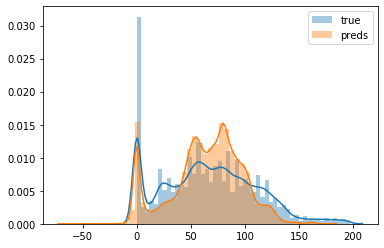

In [0]:
sns.distplot(test_df.target.values, label = 'true')
sns.distplot(predictions, label = 'preds')
plt.legend()

### Build nn

#### Design and prepare features

In [0]:
"""
------------------------------------------------------------------------------------------
NOTE OF IMPORTANTS ABOUT FEATURES:
------------------------------------------------------------------------------------------
Some features including: time_after_pr_event_in_case, ema_on_time_bet_events, month_event,
                        day_event, week_day_event and encoded categorical features are de-
signed in the sections above (altogether with target), so scroll up to get there.

In this section we design new features for continuous input for our NN.

"""

##### Design features

###### ema for net worth

In [0]:
cases = data_train.groupby('case concept:name')

def gen_ema_net_worth():
  for i in data_train['case concept:name'].unique():
      yield i, cases.get_group(i)

In [0]:
eventid2ema = {}

g = gen_ema_net_worth()
alpha = 0.1

for _, case in tqdm(g):
  case.sort_values(by = 'start_time_timestamp', inplace = True)
  e_ids, diffs = case['eventID '].values, case['event Cumulative net worth (EUR)'].values

  eventid2ema[e_ids[0]] = diffs[0]
  pr_ema = diffs[0]

  for e_id, diff in zip(e_ids[1:], diffs[1:]):
    current_ema = alpha * diff + (1 - alpha) * pr_ema
    pr_ema = current_ema
    eventid2ema[e_id] = current_ema

201387it [06:25, 522.15it/s]


In [0]:
data_train['ema_on_net_worth'] = data_train['eventID '].apply(lambda x: eventid2ema[x])

###### Hermitian Fourier Transform

###### Invoice goods receipt category

In [0]:
######### GR-based IV flag first, goods receipt flag second
CONS_INDEX = 5

d = {'th_way_matching_a': 0, #[True, True]
     'th_way_matching_b': 1, #[False, True]
     'tw_way_matching': 2, #[False, False]
     'consignment': 3} #[False, True] + item_type = consignment

In [0]:
eventid2cat = {}

for e_id, griv, gr, itype in zip(data_train['eventID '], data_train['case GR-Based Inv. Verif.'],
                                 data_train['case Goods Receipt'], data_train['case_item_type_encoded']):
  if griv == True and gr == True:
    eventid2cat[e_id] = 0
  elif griv == False and gr == False:
    eventid2cat[e_id] = 2
  else:
    if itype == CONS_INDEX:
      eventid2cat[e_id] = 3
    else:
      eventid2cat[e_id] = 1

In [0]:
data_train['gr_inv_gr_cat'] = data_train['eventID '].apply(lambda x: eventid2cat[x])

##### Prepare features

In [0]:
real_features = ['event Cumulative net worth (EUR)', 'case GR-Based Inv. Verif.', 'case Goods Receipt',
                 'time_after_pr_event_in_case', 'ema_on_time_bet_events', 'ema_on_net_worth']

encoded_categorical_features = ['case GR-Based Inv. Verif.', 'case Item', 'case Goods Receipt', 'month_event', 
                                'day_event', 'week_day_event', 'case_spend_area_text_encoded', 'case_company_encoded',
                                'case_document_type_encoded', 'case_sub_spend_area_text_encoded',
                                'case_purchasing_document_encoded', 'case_vendor_encoded',
                                'case_item_type_encoded', 'case_item_category_encoded',
                                'case_spend_classification_text_encoded', 'case_name_encoded',
                                'case_gr-based_inv._verif._encoded', 'case_goods_receipt_encoded',
                                'event_user_encoded', 'event_org:resource_encoded',
                                'event_concept:name_encoded', 'gr_inv_gr_cat']

cat_feats_to_sample = ['case Item', 'month_event', 
                                'day_event', 'week_day_event', 'case_spend_area_text_encoded', 'case_company_encoded',
                                'case_document_type_encoded', 'case_sub_spend_area_text_encoded',
                                'case_purchasing_document_encoded', 'case_vendor_encoded',
                                'case_item_type_encoded', 'case_item_category_encoded',
                                'case_spend_classification_text_encoded', 'case_name_encoded',
                                'case_gr-based_inv._verif._encoded', 'case_goods_receipt_encoded',
                                'event_user_encoded', 'event_org:resource_encoded',
                                'event_concept:name_encoded', 'gr_inv_gr_cat']

target = ['target']

nn_features = real_features + encoded_categorical_features + target

In [0]:
data_train_nn = data_train.loc[:, nn_features + ['case concept:name']]

In [0]:
print('nans in data: {n}'.format(n = np.any(data_train_nn.isna())))

nans in data: False


In [0]:
data_train_nn.to_csv('./gdrive/My Drive/data_train_nn.csv', index = False)

In [0]:
data_train.to_csv('./gdrive/My Drive/data_train_3.csv', index = False) ########## here important issue: case Item are not encoded properly, so
                                                                        ############ it is not coherent with number of unique values, so you can not
                                                                        ############ properly design embedding matrix for that

#### Train word2vec embeddings

##### Set up

In [0]:
CAT_FEAT = 'event_concept:name_encoded'
REAL_FEAT = 'event Cumulative net worth (EUR)'

WINDOW_SIZE = 5
gpus = tf.config.experimental.list_logical_devices(device_type= 'GPU')

VOCAB_SIZE = len(word2id) + 1
EMBED_DIM = 20
LR = 3e-04
NUM_EPOCHS = 1
BATCH_SIZE = 1000

##### Prepare data

In [0]:
data_train_nn = pd.read_csv('./gdrive/My Drive/data_train_nn.csv',
                            dtype = {'case GR-Based Inv. Verif.': np.int32,
                                     'case Goods Receipt': np.int32})

In [0]:
q1, q2, q3 = np.quantile(data_train_nn.target, [0.25, 0.5, 0.75])

with open('/content/gdrive/My Drive/maps_from_cat2index/event_concept:name_encoded_map.pickle', 'rb') as file:
  cat2index = pickle.load(file)
index2cat = {k: v for v, k in cat2index.items()}

In [0]:
with open(DIR2Q, 'wb') as file:
  pickle.dump([q1, q2, q3], file)

In [0]:
def foo(x):
  if x < q1:
    return 0
  elif x < q2:
    return 1
  elif x < q3:
    return 2
  else:
    return 3

data_train_nn['bin'] = data_train_nn[REAL_FEAT].apply(lambda x: foo(x))

In [0]:
def foo(x):
  return index2cat[x[CAT_FEAT]] + '_{s}'.format(s = x.bin)

data_train_nn['word'] = data_train_nn.apply(foo, axis = 1)

In [0]:
data_train_nn.to_csv('./gdrive/My Drive/data_train_nn_words.csv', index = False)

In [0]:
groups = data_train_nn.groupby('case concept:name')

def gen():
  for key in groups.groups.keys():
    yield key, groups.get_group(key)

In [0]:
word2id = {v: k for k, v in enumerate(data_train_nn.word.unique())}

In [0]:
with open(DIR2WORD2ID, 'wb') as file:
  pickle.dump(word2id, file)

In [0]:
g = gen()

with open('sentences.csv', 'w') as file:
  file.write('case,seq\n')
  for  _, group in tqdm(g):
    sentence = ' '.join(list(map(str, [word2id[elem] for elem in group.word.values])))
    file.write(_ + ',' + sentence + '\n')



201387it [03:13, 1103.26it/s]


##### Prepare dataset

In [0]:
sentences = pd.read_csv('sentences.csv').seq.values

In [0]:
with open('pairs_w2v.csv', 'w') as file:
  file.write('target,context\n')
  for sentence in tqdm(sentences):
    sentence = sentence.split()
    for pos, word in enumerate(sentence):
      index_range = list(range(max(0, pos - WINDOW_SIZE), pos)) + list(range(pos + 1, min(pos + WINDOW_SIZE, len(sentence) - 1)))
      for index in index_range:
        file.write(word + ',' + sentence[index] + '\n')

100%|██████████| 201387/201387 [00:05<00:00, 36329.75it/s]


##### Prepare model

In [0]:
with open(DIR2WORD2ID, 'rb') as file:
  word2id = pickle.load(file)

In [0]:
df = pd.read_csv('pairs_w2v.csv')
X, y = df.target.values, df.context.values

In [0]:
def _gen_one_raw():
    for x, y_it in zip(X, y):
        yield x, y_it

In [0]:
def _generate_batch(batch_size):
    dataset = tf.data.Dataset.from_generator(_gen_one_raw,
                                           output_shapes = (tf.TensorShape([]), tf.TensorShape([])),
                                           output_types = (tf.int32, tf.int32))

    dataset = dataset.prefetch(-1)
    dataset = dataset.repeat().batch(batch_size, drop_remainder = True)
    iterator = dataset.make_one_shot_iterator()
    batch = iterator.get_next()
    return batch

In [0]:
def train_input():
    return _generate_batch(len(gpus) * BATCH_SIZE)

In [0]:
def _locate_var_on_cpu(name, shape, init, trainable = True):
    with tf.device('/cpu:0'):
        var = tf.get_variable(name = name,
                              shape = tf.TensorShape(shape),
                              initializer = init,
                              trainable = trainable)

    return var

In [0]:
def compute_logits_for_tower(x, reuse_variables):
    with tf.variable_scope('Embeddings', reuse = reuse_variables):
        E = _locate_var_on_cpu('embeddings',
                               [VOCAB_SIZE, EMBED_DIM],
                               tf.contrib.layers.xavier_initializer())
    z = tf.nn.embedding_lookup(E, x)

    with tf.variable_scope('Outter_embeddings', reuse = reuse_variables):
        OE = _locate_var_on_cpu('o_embeddings',
                                [VOCAB_SIZE, EMBED_DIM],
                                tf.contrib.layers.xavier_initializer())
    logits = tf.matmul(z, tf.transpose(OE))

    return logits

In [0]:
def calculate_loss(logits, g_truth, scope):
    with tf.name_scope('main_comp'):
        m_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = g_truth,
                                                                logits = logits))

        tf.add_to_collection('losses', m_loss)

        loss = tf.reduce_sum(tf.get_collection('losses', scope = scope))

        tf.add_to_collection('tower_losses', loss)

    return loss

In [0]:
def average_gradients():
    grads_and_vars = tf.get_collection('grads_and_vars')
    averaged_grads_and_vars = []
    
    for elem in zip(*grads_and_vars):
        average_gradient = []
        shape = tf.shape(elem[0][0])
        for grad, var in elem:
            grad = tf.reshape(grad, (-1, ))
            average_gradient.append(grad)
        average_gradient = tf.reduce_mean(average_gradient, axis = 0)
        average_gradient = tf.reshape(average_gradient, shape, name = 'gradient_at_{v}'.format(v = var.op.name))
        averaged_grads_and_vars.append((average_gradient, var))
        
    return averaged_grads_and_vars

In [0]:
def build(graph):
    reuse_variables = False

    summaries = []

    with graph.as_default():
        with tf.device('/cpu:0'):
            with tf.variable_scope('set_up', reuse = reuse_variables):
                step = _locate_var_on_cpu('global_step',
                                          [],
                                          tf.constant_initializer([0]),
                                          False)

                optimizer = tf.train.AdamOptimizer(LR)

                with tf.name_scope('queue_set_up'):
                    x_q_input, y_q_input = train_input()
                    queue = tf.contrib.slim.prefetch_queue.prefetch_queue([x_q_input, y_q_input], 
                                                                        capacity = 2)
                    x, y = queue.dequeue()

            for index, gpu in enumerate(gpus):
                with tf.device(gpu.name):
                    with tf.name_scope('tower_{t}'.format(t = index)):
                        x_tower = x[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]
                        y_tower = y[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]

                        logits = compute_logits_for_tower(x_tower, reuse_variables)

                        loss = calculate_loss(logits, y_tower, scope = 'tower_{t}'.format(t = index))

                        grads_vars = optimizer.compute_gradients(loss)

                        tf.add_to_collection('grads_and_vars', grads_vars)

                        reuse_variables = True

            loss_s = tf.reduce_mean(tf.get_collection('tower_losses'))
            loss_summary = tf.summary.scalar('total_loss', loss_s)
            summaries.append(loss_summary)

            grads_vars_a = average_gradients()

            train_op = optimizer.apply_gradients(grads_vars_a, global_step = step, name = 'train_op')

            with tf.name_scope('gradients_summary'):
                for grad, var in grads_vars_a:
                    if grad is not None:
                        summaries.append(tf.summary.histogram('gradient_at_{n}'.format(n = var.op.name), 
                                                      grad))

            with tf.name_scope('vars_summary'):
                for var in tf.trainable_variables():
                    summaries.append(tf.summary.histogram('value_at_{n}'.format(n = var.op.name),
                                                    var))

            merge_op = tf.summary.merge(summaries, name = 'merge_opera')

            with tf.name_scope('saving'):
                saver = tf.train.Saver()

    return step, train_op, merge_op, saver

##### Fit word2vec embeddings model

In [0]:
graph = tf.Graph()

step, train_op, merge_op, saver = build(graph)

In [0]:
! rm -r './word2vec_embeddings'

In [0]:
### to ensure we use TB in appropriate way: we accumulate data of different
### training runs in different subdirectories of main log directory,
### so when you start TB it shows all the runs in comparing to each other

### note also, that if you use tb 1.14, then you should upgrade it via
### conda, so the error: Normalising Names Failed (Graph) wont appear
### and notice, if you work in multiple environment you should start 
### tb from the environment, where upgraded tb is placed
now = datetime.datetime.now()
logdir = os.path.join(os.getcwd(), 'word2vec_embeddings')
current_time = now.strftime("%Y%m%d-%H%M%S")
current_logdir_train = os.path.join(logdir, current_time)

PATH_TO_SAVE = './word2vec_embeddings_saved/ckpt'

In [0]:
configure = tf.ConfigProto(allow_soft_placement = True, log_device_placement = True)

In [0]:
current_step = 0

num_steps = NUM_EPOCHS * (len(X) // ((len(gpus) * BATCH_SIZE)))

In [0]:
with tf.Session(graph = graph, config = configure) as sess:
    writer_train = tf.summary.FileWriter(current_logdir_train, graph = graph)
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(sess = sess, coord = coord)
    
    run_options = tf.RunOptions(trace_level = tf.RunOptions.FULL_TRACE)
    
    for _ in tqdm_notebook(range(101)):
        if current_step % 100 == 0:
            run_metadata = tf.RunMetadata()
            current_step, _, summary_train = sess.run([step, train_op, merge_op],
                                                options = run_options,
                                                run_metadata = run_metadata)
      
            writer_train.add_summary(summary_train, current_step)
            writer_train.add_run_metadata(run_metadata, 'step_{s}'.format(s = current_step))

        else:
            current_step, _, summary_train = sess.run([step, train_op, merge_op])
            writer_train.add_summary(summary_train, current_step)

    coord.request_stop()
    
    saver.save(sess = sess,
              save_path = PATH_TO_SAVE)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


##### Save embeddings

In [0]:
graph_e = tf.Graph()

with tf.Session(config = configure, graph = graph_e) as sess:
    restorer = tf.train.import_meta_graph(PATH_TO_SAVE + '.meta')
    restorer.restore(sess,
                     PATH_TO_SAVE)
    
    e = graph_e.get_tensor_by_name('Embeddings/embeddings:0').eval()
    
  

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

INFO:tensorflow:Restoring parameters from ./word2vec_embeddings_saved/ckpt


In [0]:
with open(os.path.join(PATH2W2VEMBEDDINGS, 'word2vec_embeddings.pickle'), 'wb') as file:
    pickle.dump(e, file)

#### Train embeddings for categorical features

##### Set up

In [0]:
BATCH_SIZE = 1000
CAT_EMBEDDING_DIM = 30
LR = 3e-04
WD = None
NUM_EPOCHS = 15

gpus = tf.config.experimental.list_logical_devices(device_type= 'GPU')

In [0]:
try:
  assert len(gpus) > 0
except AssertionError:
  print('God damn colab does not see any gpu')

##### Prepare data for embeddings

In [0]:
data_train_nn = pd.read_csv('./gdrive/My Drive/data_train_nn_words.csv',
                            dtype = {'case GR-Based Inv. Verif.': np.int32,
                                     'case Goods Receipt': np.int32})

In [0]:
########### design shapes for categorical features embeddings

shapes_i = {name: len(data_train_nn[name].unique()) for name in cat_feats_to_sample}
shapes_e = {name: max(3, min(CAT_EMBEDDING_DIM, (shapes_i[name] + 1) // 2)) for name in cat_feats_to_sample}

var_e_shapes = {name: [shapes_i[name] + 1, shapes_e[name]] for name in cat_feats_to_sample}

In [0]:
with open(DIR2EMBS_SHAPE, 'wb') as file:
  pickle.dump(var_e_shapes, file)

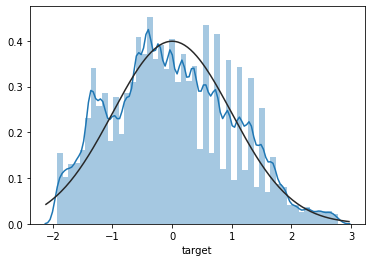

In [0]:
data_train_nn = data_train_nn[(data_train_nn.target < np.quantile(data_train_nn.target, 0.95)) &
                     (data_train_nn.target > np.quantile(data_train_nn.target, 0.05))]

mean = np.mean(data_train_nn.target.values)
std = np.std(data_train_nn.target.values)

data_train_nn['target'] = (data_train_nn['target'] - mean) / std

sns.distplot(data_train_nn.target, fit = stats.norm)
plt.savefig('file.png')

In [0]:
with open(MEAN_STD_TUPLE_DIR, 'wb') as file:
  pickle.dump(tuple([mean, std]), file)

In [0]:
######### split data into val and train for embeddings
train_index, val_index = train_test_split(data_train_nn['case concept:name'].unique(), test_size = 0.1, random_state = 0)
print('train shape {s}\nval shape {v}'.format(s = len(train_index),
                                              v = len(val_index)))

train shape 167461
val shape 18607


In [0]:
######### loc categorical features
data_train_e = data_train_nn.loc[data_train_nn['case concept:name'].isin(train_index), cat_feats_to_sample + ['target']]
data_val_e = data_train_nn.loc[data_train_nn['case concept:name'].isin(val_index), cat_feats_to_sample + ['target']]
print('train shape {s}\nval shape {v}'.format(s = data_train_e.shape, 
                                              v = data_val_e.shape))

train shape (980513, 21)
val shape (107573, 21)


##### Prepare model

In [0]:
def _gen_row_train():
  for row, target in zip(data_train_e.drop('target', axis = 1).values, data_train_e.target.values):
    yield row, target

In [0]:
def _gen_row_val():
  for row, target in zip(data_val_e.drop('target', axis = 1).values, data_val_e.target.values):
    yield row, target

In [0]:
def _gen_row_test():
  for row, target in zip(data_test_e.drop('target', axis = 1).values, data_test_e.target.values):
    yield row, target

In [0]:
def _gen_batch(generator):
  dataset = tf.data.Dataset.from_generator(generator,
                                           output_types = (tf.int32, tf.int32),
                                           output_shapes = (tf.TensorShape([20, ]), tf.TensorShape([])))
  dataset = dataset.prefetch(-1)
  dataset = dataset.repeat().batch(BATCH_SIZE, drop_remainder = True)
  iterator = dataset.make_one_shot_iterator()
  batch = iterator.get_next()
  return batch

In [0]:
def get_input_train():
  return _gen_batch(_gen_row_train)

In [0]:
def get_input_val():
  return _gen_batch(_gen_row_val)

In [0]:
def get_input_test():
  return _gen_batch(_gen_row_test)

In [0]:
def _locate_var_on_cpu(name, shape, init, trainable = True):
  with tf.device('/cpu:0'):
    var = tf.get_variable(name,
                          shape, 
                          initializer = init,
                          trainable = trainable)
  return var

In [0]:
def _locate_var_on_cpu_wd(name, shape, init, trainable = True, wd = None):
  var = _locate_var_on_cpu(name,
                           shape,
                           init,
                           trainable)
  
  if wd is not None:
    tf.add_to_collection('losses', tf.multiply(tf.reduce_sum(tf.square(var)) / 2, wd))

  return var

In [0]:
def compute_logits(x, reuse_variables):
  with tf.variable_scope('embedding_matricies', reuse = reuse_variables):
    embedding_matricies = [_locate_var_on_cpu_wd('_'.join(re.sub(r'\W', ' ', name).split()),
                                                 var_e_shapes[name],
                                                 tf.contrib.layers.xavier_initializer(),
                                                 True,
                                                 WD) for name in cat_feats_to_sample]
  for params, feat in zip(embedding_matricies, tf.split(x, num_or_size_splits= 20, axis = 1)):
    tf.add_to_collection('embedded_feats', tf.squeeze(tf.nn.embedding_lookup(params, feat)))
  embedded_batch = tf.concat(tf.get_collection('embedded_feats'), axis = 1)

  with tf.variable_scope('first_dense', reuse = reuse_variables):
    w0 = _locate_var_on_cpu_wd('w', [291, 512], tf.contrib.layers.xavier_initializer(), wd = WD)
    b0 = _locate_var_on_cpu_wd('b', [512, ], tf.zeros_initializer(), wd = WD)
  z0 = tf.nn.elu(tf.matmul(embedded_batch, w0) + b0)

  with tf.variable_scope('second_dense', reuse = reuse_variables):
    w1 = _locate_var_on_cpu_wd('w', [512, 256], tf.contrib.layers.xavier_initializer(), wd = WD)
    b1 = _locate_var_on_cpu_wd('b', [256, ], tf.zeros_initializer(), wd = WD)
  z1 = tf.nn.elu(tf.matmul(z0, w1) + b1)

  with tf.variable_scope('third_dense', reuse = reuse_variables):
    w2 = _locate_var_on_cpu_wd('w', [256, 128], tf.contrib.layers.xavier_initializer(), wd = WD)
    b2 = _locate_var_on_cpu_wd('b', [128, ], tf.zeros_initializer(), wd = WD)
  z2 = tf.nn.elu(tf.matmul(z1, w2) + b2)

  with tf.variable_scope('forth_dense', reuse = reuse_variables):
    w3 = _locate_var_on_cpu_wd('w', [128, 64], tf.contrib.layers.xavier_initializer(), wd = WD)
    b3 = _locate_var_on_cpu_wd('b', [64, ], tf.zeros_initializer(), wd = WD)
  z3 = tf.nn.elu(tf.matmul(z2, w3) + b3)

  with tf.variable_scope('fivth_dense', reuse = reuse_variables):
    w4 = _locate_var_on_cpu_wd('w', [64, 32], tf.contrib.layers.xavier_initializer(), wd = WD)
    b4 = _locate_var_on_cpu_wd('b', [32, ], tf.zeros_initializer(), wd = WD)
  z4 = tf.nn.elu(tf.matmul(z3, w4) + b4)

  with tf.variable_scope('sixth_dense', reuse = reuse_variables):
    w5 = _locate_var_on_cpu_wd('w', [32, 1], tf.contrib.layers.xavier_initializer(), wd = WD)
    b5 = _locate_var_on_cpu_wd('b', [1, ], tf.zeros_initializer(), wd = WD)
  logits = tf.squeeze(tf.matmul(z4, w5) + b5)

  return logits

In [0]:
def calculate_loss(logits, g_truth, scope, mean, std):
  g_truth = tf.cast(g_truth, dtype = tf.float64)
  logits = tf.cast(logits, dtype = tf.float64)

  with tf.name_scope('main_loss'):
    main_loss = tf.reduce_mean(tf.square(logits - g_truth))

  tf.add_to_collection('losses', main_loss)

  loss = tf.reduce_sum(tf.get_collection('losses', scope = scope))

  tf.add_to_collection('tower_losses', loss)

  with tf.name_scope('test_loss'):
    test_loss = tf.reduce_mean(tf.abs((tf.multiply(logits, std) + mean) - (tf.multiply(g_truth, std) + mean)))
    tf.add_to_collection('test_losses', test_loss)

  return loss

In [0]:
def average_gradients():
    grads_and_vars = tf.get_collection('grads_and_vars')
    averaged_grads_and_vars = []
    
    for elem in zip(*grads_and_vars):
        average_gradient = []
        shape = tf.shape(elem[0][0])
        for grad, var in elem:
            grad = tf.reshape(grad, (-1, ))
            average_gradient.append(grad)
        average_gradient = tf.reduce_mean(average_gradient, axis = 0)
        average_gradient = tf.reshape(average_gradient, shape, name = 'gradient_at_{v}'.format(v = var.op.name))
        averaged_grads_and_vars.append((average_gradient, var))
        
    return averaged_grads_and_vars

In [0]:
def build(graph, mean, std):
  reuse_variables = False
  summaries = []

  with graph.as_default():
    with tf.device('/cpu:0'):
      with tf.name_scope('inputs'):
        step = _locate_var_on_cpu('global_step',
                                  tf.TensorShape([]),
                                  tf.constant_initializer(0),
                                  trainable = False)
        
        flag_train_val_test = _locate_var_on_cpu('flag_train_val_test',
                                            tf.TensorShape([]),
                                            tf.constant_initializer(0),
                                            trainable = False)
        
        assign_for_test_op = tf.assign(flag_train_val_test, tf.constant(-1.), name = 'assign_for_test_op')

        assign_for_val_op = tf.assign(flag_train_val_test, flag_train_val_test + 1, name = 'assign_for_val_op')

        test_flag = tf.math.greater_equal(flag_train_val_test, tf.constant(0.))

        val_flag = tf.cast(tf.math.floormod(flag_train_val_test, tf.constant(2.)), tf.bool)
        
        optimizer = tf.train.AdamOptimizer(LR)

        mean_holder = tf.constant(mean)
        std_holder = tf.constant(std)

        with tf.name_scope('queue_set_up'):
          @tf.function
          def train_val_input():
            out = tf.cond(val_flag,
                          get_input_val,
                          get_input_train)
            return out

          x_q_input, y_q_input = tf.cond(test_flag,
                                         train_val_input,
                                         get_input_test)
          queue = tf.contrib.slim.prefetch_queue.prefetch_queue([x_q_input, y_q_input],
                                                                capacity = 2)
          x, y = queue.dequeue()

      for index, gpu in enumerate(gpus):
        with tf.device(gpu.name):
          with tf.name_scope('tower_{t}'.format(t = index)):
            x_tower = x[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]
            y_tower = y[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]

            logits = compute_logits(x_tower, 
                                    reuse_variables)
            
            tf.add_to_collection('logits', logits)
            
            loss = calculate_loss(logits, 
                                  y_tower,
                                  'tower_{t}'.format(t = index),
                                  mean_holder,
                                  std_holder)
            
            summaries.append(tf.summary.scalar('loss_at_tower_{t}'.format(t = index),
                                              loss))
            
            grads_vars = optimizer.compute_gradients(loss)

            tf.add_to_collection('grads_and_vars', grads_vars)

            reuse_variables = True
          
      total_loss = tf.reduce_mean(tf.get_collection('tower_losses'))

      loss_summary = tf.summary.scalar('loss_total', total_loss)
      summaries.append(loss_summary)

      test_loss_averaged = tf.reduce_mean(tf.get_collection('test_losses'), name = 'test_loss')
      
      logits_agregated = tf.concat(tf.get_collection('logits'),
                                  axis = 0,
                                  name = 'logits_aggregation')



      grads_and_vars = average_gradients()

      with tf.name_scope('summaries_gradients'):
          for grad, var in grads_and_vars:
              if grad is not None:
                  summaries.append(tf.summary.histogram('grad_for_var_{v}'.format(v = var.op.name),
                                                    grad))

      with tf.name_scope('summaries_variables'):
          for var in tf.trainable_variables():
              summaries.append(tf.summary.histogram('val_for_{v}'.format(v = var.op.name),
                                              var))

      train_op = optimizer.apply_gradients(grads_and_vars, global_step = step, name = 'update_grad_op')

      merge_op = tf.summary.merge(summaries, name = 'merge_training')
      merge_op_val = tf.summary.merge([loss_summary], name = 'val_merging')

      with tf.name_scope('saving_and_restoring'):
          saver = tf.train.Saver()

  return step, train_op, merge_op, merge_op_val, assign_for_val_op, saver

##### Fit embeddings model

In [0]:
graph = tf.Graph()

step, train_op, merge_op, merge_op_val, assign_for_val_op, saver = build(graph, mean, std)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [0]:
! rm -r './embeddings_nn'

rm: cannot remove './embeddings_nn': No such file or directory


In [0]:
### to ensure we use TB in appropriate way: we accumulate data of different
### training runs in different subdirectories of main log directory,
### so when you start TB it shows all the runs in comparing to each other

### note also, that if you use tb 1.14, then you should upgrade it via
### conda, so the error: Normalising Names Failed (Graph) wont appear
### and notice, if you work in multiple environment you should start 
### tb from the environment, where upgraded tb is placed
now = datetime.datetime.now()
logdir = os.path.join(os.getcwd(), 'embeddings_nn')
current_time = now.strftime("%Y%m%d-%H%M%S")
current_logdir_train = os.path.join(logdir, current_time, 'train')
current_logdir_val = os.path.join(logdir, current_time, 'val')

PATH_TO_SAVE = './embeddings_nn_saved/ckpt'

In [0]:
configure = tf.ConfigProto(allow_soft_placement = True, log_device_placement = False)

In [0]:
current_step = 0

num_steps = NUM_EPOCHS * (len(data_train_e) // ((len(gpus) * BATCH_SIZE)))

In [0]:
with tf.Session(graph = graph, config = configure) as sess:
    writer_train = tf.summary.FileWriter(current_logdir_train, graph = graph)
    writer_val = tf.summary.FileWriter(current_logdir_val, graph = graph)
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(sess = sess, coord = coord)
    
    run_options = tf.RunOptions(trace_level = tf.RunOptions.FULL_TRACE)
    
    for _ in tqdm_notebook(range(10)):
        if current_step % 100 == 0:
            run_metadata = tf.RunMetadata()
            current_step, _, summary_train = sess.run([step, train_op, merge_op],
                                                options = run_options,
                                                run_metadata = run_metadata)
            
                  
            _ = sess.run(assign_for_val_op)
            summary_val, _ = sess.run([merge_op_val, assign_for_val_op])
            
            writer_train.add_summary(summary_train, current_step)
            writer_train.add_run_metadata(run_metadata, 'step_{s}'.format(s = current_step))
            
            writer_val.add_summary(summary_val, current_step)
        else:
            current_step, _, summary_train = sess.run([step, train_op, merge_op])
            writer_train.add_summary(summary_train, current_step)
     
    coord.request_stop()
    
    saver.save(sess = sess,
              save_path = PATH_TO_SAVE)
    
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('./timeline_finish_step.json', 'w') as f:
        f.write(chrome_trace)
        

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Instructions for updating:
To construct input pipelines, use the `tf.data` module.



Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


##### Merge embeddings with num features

###### Import pretrained embeddings

In [0]:
############ embeddings for categorical features

graph_embs = tf.Graph()

with tf.Session(config = configure, graph = graph_embs) as sess:
  restorer = tf.train.import_meta_graph(PATH_TO_SAVE + '.meta')
  restorer.restore(sess = sess,
                   save_path = PATH_TO_SAVE)
  for feat in cat_feats_to_sample:
    name = '_'.join(re.sub(r'\W', ' ', feat).split())
    tensor_name = 'embedding_matricies/' +  name
    tensor = graph_embs.get_tensor_by_name(tensor_name + ':0').eval()
    with open(os.path.join(EMBEDS_DIR, name + '.pickle'), 'wb') as file:
      pickle.dump(tensor, file)

INFO:tensorflow:Restoring parameters from ./embeddings_nn_saved/ckpt


In [0]:
############### word2vec embeddings

with open(DIR2WORD2ID, 'rb') as file:
    word2id = pickle.load(file)

with open(os.path.join(PATH2W2VEMBEDDINGS, 'word2vec_embeddings.pickle'), 'rb') as file:
    w2v_embeddings = pickle.load(file)

###### Merge

In [0]:
############## merge word2vec

words_encoded = [word2id[elem] for elem in data_train_nn.word.values]

w2vfeatures = w2v_embeddings[words_encoded]

In [0]:
############## categorical features embeddings

embeddings = {}

for feat in cat_feats_to_sample:
  name = '_'.join(re.sub(r'\W', ' ', feat).split())
  with open(os.path.join(EMBEDS_DIR, name + '.pickle'), 'rb') as file:
    embeddings[name] = pickle.load(file)


In [0]:
for index, feat in tqdm(enumerate(var_e_shapes.keys())):
  name = '_'.join(re.sub(r'\W', ' ', feat).split())
  embeddings_matrix = embeddings[name]
  
  feat_val = data_train_nn[feat].values
  if index == 0:
    embedded_data = embeddings_matrix[feat_val]
  else:
    embedded_data = np.column_stack((embedded_data, embeddings_matrix[feat_val]))

20it [00:06,  2.06it/s]


In [0]:
columns = []

for feat in var_e_shapes.keys():
  feat_dims_e = shapes_e[feat]
  for i in range(feat_dims_e):
    columns.append(feat + str(i))

columns.extend(['w2v_feature_{s}'.format(s = elem) for elem in range(EMBED_DIM)])

In [0]:
embedded_df = pd.DataFrame(data = np.column_stack((embedded_data, w2vfeatures)) , columns = columns, index = data_train_nn.index)

In [0]:
df_real = data_train_nn.loc[:, real_features + ['case concept:name']]

In [0]:
embedded_and_real_df = pd.concat((df_real, embedded_df), axis = 1)

In [0]:
embedded_and_real_df['target'] = data_train_nn['target']

###### Group in subcases

In [0]:
cases = embedded_and_real_df.groupby(['case concept:name'])

In [0]:
def gencases():
  for key in tqdm_notebook(pd.unique(embedded_and_real_df['case concept:name'])):
    group = cases.get_group(key)
    indexes = group.index
    if len(group) > 2:
      for i in range(len(indexes) - 2):
        subgroup = group.iloc[:i + 1, group.columns != 'target']
        subcase = np.mean(subgroup.drop('case concept:name', axis = 1).values, axis = 0)
        sum_cumulative_net_worth = sum(subgroup['event Cumulative net worth (EUR)'])
        num_of_cases = len(subgroup)
        subtarget = group['target'].values[0]
        case = np.append(subcase, [sum_cumulative_net_worth, num_of_cases, subtarget])
        yield case

In [0]:
cols = list(embedded_and_real_df.columns)
cols.remove('target')
cols.remove('case concept:name')
columns = cols + ['sum_cumulative_net_worth', 'num_of_cases', 'target']


In [0]:
g = gencases()

with open('/content/subcases_nn.csv', 'w') as file:
  file.write(','.join(columns) + '\n')
  for case in g:
    case_str = list(map(lambda x: str(x), case))
    file.write(','.join(case_str) + '\n')

In [0]:
! cp 'subcases_nn.csv' './gdrive/My Drive/subcases_nn.csv'

#### Compile final model

###### Set up

In [0]:
BATCH_SIZE = 1000
LR = 3e-04
WDECAY = None
NUM_EPOCHS = 20

gpus = tf.config.experimental.list_logical_devices(device_type= 'GPU')

In [0]:
try:
  assert len(gpus) > 0
except AssertionError:
  print('God damn colab does not see any gpu')

##### Prepare data

In [0]:
data = pd.read_csv('/content/gdrive/My Drive/subcases_nn.csv')

In [0]:
def _fft(a):
  return [elem.real for elem in np.fft.fft(a)]

def _scaled_fft(a):
  a = _fft(a)
  return (a - np.mean(a)) / np.std(a)

def _boxcox_m_0_5(a):
  return boxcox(a + 1, lmbda= -0.5)

def _boxcox_m_1(a):
  return boxcox(a + 1, lmbda= -1)

transformations = {'event Cumulative net worth (EUR)': np.log1p,
                   'time_after_pr_event_in_case': np.log1p,
                   'ema_on_time_bet_events': _boxcox_m_0_5,
                   'ema_on_net_worth': np.log1p,
                   'sum_cumulative_net_worth': np.log1p,
                   'num_of_cases': np.log1p,
                   }

In [0]:
for k, v in transformations.items():
  data[k] = v(data[k])

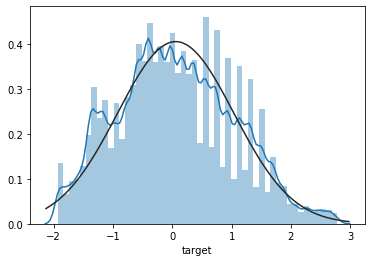

In [0]:
sns.distplot(data.target, fit = stats.norm)

In [0]:
X, y = data.drop('target', axis = 1).values, data.target.values

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X,  y, test_size = 0.1, random_state = 0)

In [0]:
print('train shape {t}\nval shape {v}'.format(t = X_train.shape, v = X_val.shape))

train shape (644355, 319)
val shape (71595, 319)


##### Unsupervised pretraining of layers

In [0]:
mm_scaler = MinMaxScaler()
X_uns = mm_scaler.fit_transform(X)

In [0]:
def _gen_row():
  for x in X_uns:
    yield x

In [0]:
def _gen_batch():
  dataset = tf.data.Dataset.from_generator(_gen_row,
                                           output_types = (tf.float32),
                                           output_shapes = (tf.TensorShape([319, ])))
  dataset = dataset.prefetch(-1)
  dataset = dataset.repeat().batch(BATCH_SIZE, drop_remainder = True)
  iterator = dataset.make_one_shot_iterator()
  batch = iterator.get_next()
  return batch

In [0]:
def get_input():
  return _gen_batch()

In [0]:
def _locate_var_on_cpu(name, shape, init, trainable = True):
  with tf.device('/cpu:0'):
    var = tf.get_variable(name,
                          shape, 
                          initializer = init,
                          trainable = trainable)
  return var

In [0]:
def average_gradients():
    grads_and_vars = tf.get_collection('grads_and_vars')
    averaged_grads_and_vars = []
    
    for elem in zip(*grads_and_vars):
        average_gradient = []
        shape = tf.shape(elem[0][0])
        for grad, var in elem:
            grad = tf.reshape(grad, (-1, ))
            average_gradient.append(grad)
        average_gradient = tf.reduce_mean(average_gradient, axis = 0)
        average_gradient = tf.reshape(average_gradient, shape, name = 'gradient_at_{v}'.format(v = var.op.name))
        averaged_grads_and_vars.append((average_gradient, var))
        
    return averaged_grads_and_vars

In [0]:
def compute_logits(x, reuse_variables):
  with tf.variable_scope('first_dense', reuse = reuse_variables):
    w = _locate_var_on_cpu('w',
                           tf.TensorShape([319, 1024]),
                           tf.contrib.layers.xavier_initializer())
    b = _locate_var_on_cpu('b',
                           tf.TensorShape([1024, ]),
                           tf.zeros_initializer())
  z = tf.nn.sigmoid(tf.matmul(x, w) + b)

  with tf.variable_scope('back_dense', reuse = reuse_variables):
    b_ = _locate_var_on_cpu('b_', 
                            tf.TensorShape([]),
                            tf.zeros_initializer())
  logits = tf.matmul(z, tf.transpose(w)) + b_

  return logits

In [0]:
def calculate_loss(logits, x, scope):
  with tf.name_scope('main_add'):
    sums = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels = x,
                                            logits = logits),
           axis = 1)
    main_loss = tf.reduce_mean(sums)

  tf.add_to_collection('tower_losses',
                       main_loss)
  
  return main_loss

In [0]:
def build(graph):
  reuse_variables = False
  summaries = []

  with graph.as_default():
    with tf.device('/cpu:0'):
      with tf.name_scope('inputs'):
        step = _locate_var_on_cpu('global_step',
                                  tf.TensorShape([]),
                                  tf.constant_initializer(0),
                                  trainable = False)

        optimizer = tf.train.AdamOptimizer(LR)

        with tf.name_scope('queue_set_up'):
          x_q_input = get_input()

          queue = tf.contrib.slim.prefetch_queue.prefetch_queue([x_q_input],
                                                                capacity = 1)
          x = queue.dequeue()

      for index, gpu in enumerate(gpus):
        with tf.device(gpu.name):
          with tf.name_scope('tower_{t}'.format(t = index)):
            x_tower = x[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]

            logits = compute_logits(x_tower, 
                                    reuse_variables)
            
            
            loss = calculate_loss(logits, 
                                  x_tower,
                                  'tower_{t}'.format(t = index))
            
            summaries.append(tf.summary.scalar('loss_at_tower_{t}'.format(t = index),
                                              loss))
            
            grads_vars = optimizer.compute_gradients(loss)

            tf.add_to_collection('grads_and_vars', grads_vars)

            reuse_variables = True
          
      total_loss = tf.reduce_mean(tf.get_collection('tower_losses'))

      loss_summary = tf.summary.scalar('loss_total', total_loss)
      summaries.append(loss_summary)

      grads_and_vars = average_gradients()

      with tf.name_scope('summaries_gradients'):
          for grad, var in grads_and_vars:
              if grad is not None:
                  summaries.append(tf.summary.histogram('grad_for_var_{v}'.format(v = var.op.name),
                                                    grad))

      with tf.name_scope('summaries_variables'):
          for var in tf.trainable_variables():
              summaries.append(tf.summary.histogram('val_for_{v}'.format(v = var.op.name),
                                              var))

      train_op = optimizer.apply_gradients(grads_and_vars, global_step = step, name = 'update_grad_op')

      merge_op = tf.summary.merge(summaries, name = 'merge_training')

      with tf.name_scope('saving_and_restoring'):
          saver = tf.train.Saver()

  return step, train_op, merge_op, saver

In [0]:
graph = tf.Graph()

step, train_op, merge_op,  saver = build(graph)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
! rm -r './unsupervised_pretraining'

rm: cannot remove './unsupervised_pretraining': No such file or directory


In [0]:
### to ensure we use TB in appropriate way: we accumulate data of different
### training runs in different subdirectories of main log directory,
### so when you start TB it shows all the runs in comparing to each other

### note also, that if you use tb 1.14, then you should upgrade it via
### conda, so the error: Normalising Names Failed (Graph) wont appear
### and notice, if you work in multiple environment you should start 
### tb from the environment, where upgraded tb is placed
now = datetime.datetime.now()
logdir = os.path.join(os.getcwd(), 'unsupervised_pretraining')
current_time = now.strftime("%Y%m%d-%H%M%S")
current_logdir_train = os.path.join(logdir, current_time, 'train')
current_logdir_val = os.path.join(logdir, current_time, 'val')

PATH_TO_SAVE = './unsupervised_pretraining_saved/ckpt'

In [0]:
configure = tf.ConfigProto(allow_soft_placement = True, log_device_placement = False)

In [0]:
NUM_EPOCHS_UNS = 20

In [0]:
current_step = 0

num_steps = NUM_EPOCHS_UNS * (len(X_uns) // ((len(gpus) * BATCH_SIZE)))

In [0]:
with tf.Session(graph = graph, config = configure) as sess:
    writer_train = tf.summary.FileWriter(current_logdir_train, graph = graph)
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(sess = sess, coord = coord)
    
    run_options = tf.RunOptions(trace_level = tf.RunOptions.FULL_TRACE)
    
    for _ in tqdm_notebook(range(num_steps)):
        if current_step % 100 == 0:
            run_metadata = tf.RunMetadata()
            current_step, _, summary_train = sess.run([step, train_op, merge_op],
                                                options = run_options,
                                                run_metadata = run_metadata)
            
                              
            writer_train.add_summary(summary_train, current_step)
            writer_train.add_run_metadata(run_metadata, 'step_{s}'.format(s = current_step))
        else:
            current_step, _, summary_train = sess.run([step, train_op, merge_op])
            writer_train.add_summary(summary_train, current_step)
     
    coord.request_stop()
    
    saver.save(sess = sess,
              save_path = PATH_TO_SAVE)
    
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('./timeline_finish_step.json', 'w') as f:
        f.write(chrome_trace)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Instructions for updating:
To construct input pipelines, use the `tf.data` module.



Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


In [0]:
############ restore weights

graph_uns = tf.Graph()

with tf.Session(config = configure, graph = graph_uns) as sess:
  restorer = tf.train.import_meta_graph(PATH_TO_SAVE + '.meta')
  restorer.restore(sess = sess,
                   save_path = PATH_TO_SAVE)
  tensor_name = 'first_dense/w'
  weights = graph_uns.get_tensor_by_name(tensor_name + ':0').eval()

with open(os.path.join(PRETRAINED_W_DIR, 'pretrained_first_layer.pickle'), 'wb') as file:
  pickle.dump(weights, file)

INFO:tensorflow:Restoring parameters from ./unsupervised_pretraining_saved/ckpt


##### Prepare final model

In [0]:
def _locate_variable_on_cpu_wd(name, shape, init, wd, trainable = True):
    var = _locate_variable_on_cpu(name = name,
                               shape = shape,
                               init = init,
                               trainable = trainable)
    if wd is not None:
        var_wd = tf.multiply(tf.nn.l2_loss(var), wd)
        tf.add_to_collection('loss', var_wd)

    return var

In [0]:
def _locate_variable_on_cpu(name, shape, init, trainable = True):
    with tf.device('/cpu:0'):
        var = tf.get_variable(name = name,
                         shape = tf.TensorShape(shape),
                         initializer = init,
                         trainable = trainable)
    return var

In [0]:
def _gen_row_train():
  for x, y in zip(X_train, y_train):
    yield x, y

In [0]:
def _gen_row_val():
  for x, y in zip(X_val, y_val):
    yield x, y

In [0]:
def _gen_row_test():
  for x, y in zip(X_test, y_test):
    yield x, y

In [0]:
def _gen_batch(generator):
  dataset = tf.data.Dataset.from_generator(generator,
                                           (tf.float32, tf.float32),
                                           (tf.TensorShape([319, ]), tf.TensorShape([])))
  dataset = dataset.prefetch(-1)
  dataset = dataset.repeat().batch(BATCH_SIZE, drop_remainder = True)
  iterator = dataset.make_one_shot_iterator()
  batch = iterator.get_next()
  return batch

In [0]:
def construct_graph_and_return_logits(x, reuse_variables, initializers):
  with tf.variable_scope('first_dense', reuse = reuse_variables):
      w1 = _locate_variable_on_cpu_wd('w', [319, 1024], tf.constant_initializer(initializers[0]) , WDECAY)
      b1 = _locate_variable_on_cpu_wd('b', [1024, ], tf.zeros_initializer(), WDECAY)
  z1 = tf.nn.elu(tf.matmul(x, w1) + b1)

  with tf.variable_scope('second_dense', reuse = reuse_variables):
      w2 = _locate_variable_on_cpu_wd('w', [1024, 512], tf.contrib.layers.xavier_initializer(), WDECAY)
      b2 = _locate_variable_on_cpu_wd('b', [512, ], tf.zeros_initializer(), WDECAY)
  z2 = tf.nn.sigmoid(tf.matmul(z1, w2) + b2)

  with tf.variable_scope('third_dense', reuse = reuse_variables):
      w3 = _locate_variable_on_cpu_wd('w', [512, 256], tf.contrib.layers.xavier_initializer(), WDECAY)
      b3 = _locate_variable_on_cpu_wd('b', [256, ], tf.zeros_initializer(), WDECAY)
  z3 = tf.nn.elu(tf.matmul(z2, w3) + b3)

  with tf.variable_scope('fourth_dense', reuse = reuse_variables):
      w4 = _locate_variable_on_cpu_wd('w', [256, 128], tf.contrib.layers.xavier_initializer(), WDECAY)
      b4 = _locate_variable_on_cpu_wd('b', [128, ], tf.zeros_initializer(), WDECAY)
  z4 = tf.nn.sigmoid(tf.matmul(z3, w4) + b4)

  with tf.variable_scope('fivth_dense', reuse = reuse_variables):
      w5 = _locate_variable_on_cpu_wd('w', [128, 64], tf.contrib.layers.xavier_initializer(), WDECAY)
      b5 = _locate_variable_on_cpu_wd('b', [64, ], tf.zeros_initializer(), WDECAY)
  z5 = tf.nn.elu(tf.matmul(z4, w5) + b5)

  with tf.variable_scope('sixth_dense', reuse = reuse_variables):
      w6 = _locate_variable_on_cpu_wd('w', [64, 32], tf.contrib.layers.xavier_initializer(), WDECAY)
      b6 = _locate_variable_on_cpu_wd('b', [32, ], tf.zeros_initializer(), WDECAY)
  z6 = tf.nn.sigmoid(tf.matmul(z5, w6) + b6)

  with tf.variable_scope('final_dense', reuse = reuse_variables):
      w7 = _locate_variable_on_cpu_wd('w', [32, 1], tf.contrib.layers.xavier_initializer(), WDECAY)
      b7 = _locate_variable_on_cpu_wd('b', [1, ], tf.zeros_initializer(), WDECAY)
  out = tf.matmul(z6, w7) + b7

  logits = tf.squeeze(out)

  return logits

In [0]:
def compute_loss_for_tower(logits, true, scope, mean, std):
    with tf.name_scope('main_loss'):
        main_loss = tf.reduce_mean(tf.square(logits - true))

    tf.add_to_collection('loss', main_loss)

    tf.add_to_collection('main_losses', main_loss)

    loss_for_tower = tf.reduce_sum(tf.get_collection('loss', scope = scope))
    

    test_loss = tf.reduce_mean(tf.abs((tf.multiply(logits, std) + mean) - (tf.multiply(true, std) + mean)))
    tf.add_to_collection('test_losses', test_loss)
    
    return loss_for_tower

In [0]:
def construct_graph(graph, mean, std, initializers):
    reuse_variables = False

    summaries = []

    with graph.as_default():
        with tf.device('/cpu:0'):
            with tf.name_scope('things_for_set_up'):
                mean_holder = tf.constant(mean, dtype= tf.float32)
                std_holder = tf.constant(std, dtype = tf.float32)
                
                
                step = _locate_variable_on_cpu(name = 'global_step',
                                              shape = [],
                                              init = tf.constant_initializer(0),
                                              trainable = False)
                flag_for_queue = _locate_variable_on_cpu(name = 'flag_queues',
                                                        shape = [],
                                                        init = tf.constant_initializer(0),
                                                        trainable = False)
                flag_update_op = tf.assign(flag_for_queue, flag_for_queue + 1, name = 'update_flag')

                optimizer = tf.train.AdamOptimizer(3e-04)


                with tf.name_scope('inputs'):
                    flag_indicator = tf.cast(tf.math.floormod(flag_for_queue, tf.constant(2.)), tf.bool)
                    
                    @tf.function
                    def train_val_input():
                        out = tf.cond(flag_indicator,
                                    get_input_val,
                                    get_input_train)
                        return out
                    
                    assign_for_test_op = tf.assign(flag_for_queue, tf.constant(-1.), name = 'assign_for_test_op')
                    
                    flag_negative_operation = tf.math.greater_equal(flag_for_queue, tf.constant(0.))
                    
                    x_input, y_input = tf.cond(flag_negative_operation,
                                               train_val_input,
                                               get_input_test)
                    
                    queue = tf.contrib.slim.prefetch_queue.prefetch_queue([x_input, y_input],
                                                                         capacity = 2)
                    x, y = queue.dequeue()

            for index, gpu in enumerate(gpus):
                with tf.name_scope('tower{t}'.format(t = index)):
                    with tf.device(gpu.name):
                        x_tower_input = x[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]
                        y_tower_input = y[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]

                        logits  = construct_graph_and_return_logits(x_tower_input, 
                                                                   reuse_variables,
                                                                    initializers)

                        tf.add_to_collection('logits', logits)

                        loss = compute_loss_for_tower(logits, 
                                                      y_tower_input, 
                                                      'tower{t}'.format(t = index),
                                                      mean_holder,
                                                      std_holder)

                        tower_loss_summary = tf.summary.scalar('loss_for_{t}_tower'.format(t = index), loss)
                        summaries.append(tower_loss_summary)

                        grads_vars = optimizer.compute_gradients(loss)

                        tf.add_to_collection('grads_and_vars', grads_vars)

                        reuse_variables = True

            total_loss = tf.reduce_mean(tf.get_collection('main_losses'))

            loss_summary = tf.summary.scalar('loss_total', total_loss)
            summaries.append(loss_summary)

            test_loss_averaged = tf.reduce_mean(tf.get_collection('test_losses'), name = 'test_loss')
            
            logits_agregated = tf.concat(tf.get_collection('logits'),
                                        axis = 0,
                                        name = 'logits_aggregation')



            grads_and_vars = average_gradients()

            with tf.name_scope('summaries_gradients'):
                for grad, var in grads_and_vars:
                    if grad is not None:
                        summaries.append(tf.summary.histogram('grad_for_var_{v}'.format(v = var.op.name),
                                                         grad))

            with tf.name_scope('summaries_variables'):
                for var in tf.trainable_variables():
                    summaries.append(tf.summary.histogram('val_for_{v}'.format(v = var.op.name),
                                                   var))


            train_op = optimizer.apply_gradients(grads_and_vars, global_step = step, name = 'update_grad_op')

            merge_op = tf.summary.merge(summaries, name = 'merge_training')
            merge_op_val = tf.summary.merge([loss_summary], name = 'val_merging')


            with tf.name_scope('saving_and_restoring'):
                saver = tf.train.Saver()

    return step, train_op, merge_op, merge_op_val, flag_update_op, saver

##### Fit final model

In [0]:
with open(MEAN_STD_TUPLE_DIR, 'rb') as file:
  mean, std = pickle.load(file)

with open(os.path.join(PRETRAINED_W_DIR, 'pretrained_first_layer.pickle'), 'rb') as file:
  pfl = pickle.load(file)

initializers = [pfl]

In [0]:
graph = tf.Graph()

step, train_op, merge_op, merge_op_val, flag_update_op, saver = construct_graph(graph, mean, std, initializers)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [0]:
! rm -r './regression_model_embedded_cat_feats'

rm: cannot remove './regression_model_embedded_cat_feats': No such file or directory


In [0]:
### to ensure we use TB in appropriate way: we accumulate data of different
### training runs in different subdirectories of main log directory,
### so when you start TB it shows all the runs in comparing to each other

### note also, that if you use tb 1.14, then you should upgrade it via
### conda, so the error: Normalising Names Failed (Graph) wont appear
### and notice, if you work in multiple environment you should start 
### tb from the environment, where upgraded tb is placed
now = datetime.datetime.now()
logdir = os.path.join(os.getcwd(), 'regression_model_embedded_cat_feats')
current_time = now.strftime("%Y%m%d-%H%M%S")
current_logdir_train = os.path.join(logdir, current_time, 'train')
current_logdir_test = os.path.join(logdir, current_time, 'test')

PATH_TO_SAVE = './regression_model_cat_feats_embedded_saved/ckpt'

In [0]:
configure = tf.ConfigProto(allow_soft_placement = True, log_device_placement = False)

In [0]:
current_step = 0

num_steps = NUM_EPOCHS * (len(X_train) // ((len(gpus) * BATCH_SIZE)))

In [0]:
with tf.Session(graph = graph, config = configure) as sess:
    writer_train = tf.summary.FileWriter(current_logdir_train, graph = graph)
    writer_test = tf.summary.FileWriter(current_logdir_test, graph = graph)
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(sess = sess, coord = coord)
    
    run_options = tf.RunOptions(trace_level = tf.RunOptions.FULL_TRACE)
    
    for _ in tqdm_notebook(range(num_steps)):
        if current_step % 100 == 0:
            run_metadata = tf.RunMetadata()
            current_step, _, summary_train = sess.run([step, train_op, merge_op],
                                                options = run_options,
                                                run_metadata = run_metadata)
                  
            _ = sess.run(flag_update_op)
            summary_val, _ = sess.run([merge_op_val, flag_update_op])
            
            writer_train.add_summary(summary_train, current_step)
            writer_train.add_run_metadata(run_metadata, 'step_{s}'.format(s = current_step))
            
            writer_test.add_summary(summary_val, current_step)
        else:
            current_step, _, summary_train = sess.run([step, train_op, merge_op])
            writer_train.add_summary(summary_train, current_step)
     
    coord.request_stop()
    
    saver.save(sess = sess,
              save_path = PATH_TO_SAVE)
    
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('./timeline_finish_step.json', 'w') as f:
        f.write(chrome_trace)
        

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Instructions for updating:
To construct input pipelines, use the `tf.data` module.



Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


##### Test model

In [0]:
test_data = pd.read_csv('./gdrive/My Drive/subcases_nn_test.csv')

In [0]:
test_data = test_data[(test_data.target < np.quantile(test_data.target, 0.95)) & (test_data.target > np.quantile(test_data.target, 0.05))]

In [0]:
for k, v in transformations.items():
  test_data[k] = v(test_data[k])

In [0]:
X_test, y_test = test_data.drop('target', axis = 1).values, (test_data.target.values - mean) / std

In [0]:
X_test = scaler.transform(X_test)

In [0]:
losses = []
logits_predictions = []

In [0]:
num_steps_test = len(X_test) // (BATCH_SIZE * len(gpus))

In [0]:
graph_test = tf.Graph()

with graph_test.as_default():
    saver_restore = tf.train.import_meta_graph(PATH_TO_SAVE + '.meta')
    assign_op = graph_test.get_operation_by_name('things_for_set_up/inputs/assign_for_test_op')
    test_loss = graph_test.get_tensor_by_name('test_loss:0')
    predictions = graph_test.get_tensor_by_name('logits_aggregation/logits_aggregation:0')

    
    with tf.Session(config = configure) as sess:
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        tf.train.start_queue_runners(sess = sess,
                                    coord = coord)        
        
        saver_restore.restore(sess,
                             PATH_TO_SAVE)
                
        sess.run(assign_op)
        
        for _ in tqdm_notebook(range(num_steps_test)):
            loss, pred = sess.run([test_loss, predictions])
            losses.append(loss)
            logits_predictions.append(pred)
        
        coord.request_stop()

INFO:tensorflow:Restoring parameters from ./regression_model_cat_feats_embedded_saved/ckpt


In [0]:
########### current best: 10.600329132080078

In [0]:
print('number of days {d}'.format(d = np.mean(losses)))

number of days 11.611770629882812


In [0]:
logits_to_plot = list(chain(*logits_predictions))

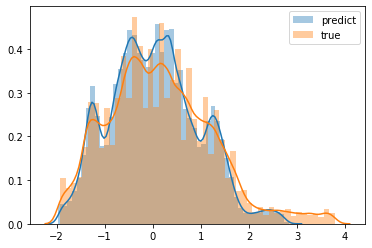

In [0]:
sns.distplot(logits_to_plot, label = 'predict')
sns.distplot(y_test, label = 'true')
plt.legend()

In [0]:
np.mean(y_test * std + mean)

77.40567389853503

##### Test data aggregation

###### Prepare test data

In [0]:
test_data = pd.read_csv('./gdrive/My Drive/data_test.csv')

In [0]:
print('test shape {t}'.format(t = test_data.shape))

test shape (321952, 22)


###### Encode features

In [0]:
cat_feats = ['case Spend area text', 'case Company', 'case Document Type', 'case Sub spend area text',
             'case Purchasing Document', 'case Vendor', 'case Item Type', 'case Item Category',
             'case Spend classification text', 'case Name', 'case GR-Based Inv. Verif.',
             'case Goods Receipt', 'event User', 'event org:resource', 'event concept:name']

for feat in cat_feats:
  feat_ = '_'.join(feat.lower().split()) + '_encoded'
  with open(os.path.join(DIR2MAPS, feat_ + '_map.pickle'), 'rb') as file:
    feat2index = pickle.load(file)
    test_data[feat_] = test_data[feat].apply(lambda x: feat2index[x] if x in feat2index else feat2index['unk'])

In [0]:
test_data.drop(cat_feats + ['case Purch. Doc. Category name', 'case Source'], axis = 1, inplace = True)

In [0]:
with open('/content/gdrive/My Drive/maps_from_cat2index/case_Item.pickle', 'rb') as file:
  d = pickle.load(file)

test_data['case Item'] = test_data['case Item'].apply(lambda x: d[x] if x in d else d['unk'])

###### Construct cat features for test and embedd them

In [0]:
t_D = targetDesigner(test_data)
test_data = (t_D
              .construct_target()
              .return_transformed_data())

50347it [00:48, 1038.80it/s]


In [0]:
d = TimeFromPrEvent(test_data)
test_data = (d
             .makeVocab()
             .updateData())

50347it [02:02, 410.38it/s]


In [0]:
test_data = (d
             .constructEMA()
             .updateDataEma())

50347it [01:35, 529.30it/s]


In [0]:
test_data['month_event'] = test_data.start_time_timestamp.apply(lambda x: x.month)

test_data['day_event'] = test_data.start_time_timestamp.apply(lambda x: x.day)

test_data['week_day_event'] = test_data.start_time_timestamp.apply(lambda x: x.weekday())


In [0]:
cases = test_data.groupby('case concept:name')

def gen_ema_net_worth():
  for i in test_data['case concept:name'].unique():
      yield i, cases.get_group(i)

eventid2ema = {}

g = gen_ema_net_worth()
alpha = 0.1

for _, case in tqdm(g):
  case.sort_values(by = 'start_time_timestamp', inplace = True)
  e_ids, diffs = case['eventID '].values, case['event Cumulative net worth (EUR)'].values

  eventid2ema[e_ids[0]] = diffs[0]
  pr_ema = diffs[0]

  for e_id, diff in zip(e_ids[1:], diffs[1:]):
    current_ema = alpha * diff + (1 - alpha) * pr_ema
    pr_ema = current_ema
    eventid2ema[e_id] = current_ema

test_data['ema_on_net_worth'] = test_data['eventID '].apply(lambda x: eventid2ema[x])

50347it [01:32, 544.12it/s]


In [0]:
CONS_INDEX = 5

eventid2cat = {}

for e_id, griv, gr, itype in zip(test_data['eventID '], test_data['case_gr-based_inv._verif._encoded'],
                                 test_data['case_goods_receipt_encoded'], test_data['case_item_type_encoded']):
  if griv == 1 and gr == 1:
    eventid2cat[e_id] = 0
  elif griv == 0 and gr == 0:
    eventid2cat[e_id] = 2
  else:
    if itype == CONS_INDEX:
      eventid2cat[e_id] = 3
    else:
      eventid2cat[e_id] = 1

In [0]:
test_data['gr_inv_gr_cat'] = test_data['eventID '].apply(lambda x: eventid2cat[x])

In [0]:
embeddings = {}

for feat in cat_feats_to_sample:
  name = '_'.join(re.sub(r'\W', ' ', feat).split())
  with open(os.path.join(EMBEDS_DIR, name + '.pickle'), 'rb') as file:
    embeddings[name] = pickle.load(file)


In [0]:
with open(DIR2EMBS_SHAPE, 'rb') as file:
  var_e_shape = pickle.load(file)

for index, feat in tqdm(enumerate(var_e_shapes.keys())):
  name = '_'.join(re.sub(r'\W', ' ', feat).split())
  embeddings_matrix = embeddings[name]
  
  feat_val = test_data[feat].values
  if index == 0:
    embedded_data = embeddings_matrix[feat_val]
  else:
    embedded_data = np.column_stack((embedded_data, embeddings_matrix[feat_val]))

20it [00:02,  5.56it/s]


In [0]:
########### word2vec features

CAT_FEAT = 'event_concept:name_encoded'
REAL_FEAT = 'event Cumulative net worth (EUR)'
EMBED_DIM = 20

with open(DIR2Q, 'rb') as file:
  q1, q2, q3 = pickle.load(file)

with open(DIR2WORD2ID, 'rb') as file:
  word2id = pickle.load(file)

with open(os.path.join(PATH2W2VEMBEDDINGS, 'word2vec_embeddings.pickle'), 'rb') as file:
    w2v_embeddings = pickle.load(file)

with open('/content/gdrive/My Drive/maps_from_cat2index/event_concept:name_encoded_map.pickle', 'rb') as file:
  cat2index = pickle.load(file)
index2cat = {k: v for v, k in cat2index.items()}

def foo(x):
  if x < q1:
    return 0
  elif x < q2:
    return 1
  elif x < q3:
    return 2
  else:
    return 3

def f(x):
  return index2cat[x[CAT_FEAT]] + '_{s}'.format(s = x.bin)

test_data['bin'] = test_data[REAL_FEAT].apply(lambda x: foo(x))
test_data['word'] = test_data.apply(lambda x: f(x), axis = 1)

In [0]:
############## word2vec features

words = [word2id[elem] if elem in word2id else len(word2id) for elem in test_data.word.values]

w2v_features = w2v_embeddings[words]

In [0]:
columns = []

for feat in var_e_shapes.keys():
  feat_dims_e = shapes_e[feat]
  for i in range(feat_dims_e):
    columns.append(feat + str(i))

columns.extend(['w2v_feature_{s}'.format(s = elem) for elem in range(EMBED_DIM)])

In [0]:
embedded_df = pd.DataFrame(data = np.column_stack((embedded_data, w2v_features)), columns = columns, index = test_data.index)

In [0]:
df_real = test_data.loc[:, real_features + ['case concept:name']]

In [0]:
embedded_and_real_df = pd.concat((df_real, embedded_df), axis = 1)

In [0]:
embedded_and_real_df['target'] = test_data['target']

In [0]:
embedded_and_real_df['case GR-Based Inv. Verif.'] = test_data['case GR-Based Inv. Verif.'].astype(np.int32)

In [0]:
embedded_and_real_df['case Goods Receipt'] = test_data['case Goods Receipt'].astype(np.int32)

###### Make subcases

In [0]:
cases = embedded_and_real_df.groupby(['case concept:name'])

In [0]:
def gencases():
  for key in tqdm_notebook(pd.unique(embedded_and_real_df['case concept:name'])):
    group = cases.get_group(key)
    indexes = group.index
    if len(group) > 2:
      for i in range(len(indexes) - 2):
        subgroup = group.iloc[:i + 1, group.columns != 'target']
        subcase = np.mean(subgroup.drop('case concept:name', axis = 1).values, axis = 0)
        sum_cumulative_net_worth = sum(subgroup['event Cumulative net worth (EUR)'])
        num_of_cases = len(subgroup)
        subtarget = group['target'].values[0]
        case = np.append(subcase, [sum_cumulative_net_worth, num_of_cases, subtarget])
        yield case

In [0]:
cols = list(embedded_and_real_df.columns)
cols.remove('target')
cols.remove('case concept:name')
columns = cols + ['sum_cumulative_net_worth', 'num_of_cases', 'target']


In [0]:
g = gencases()

with open('/content/subcases_nn_test.csv', 'w') as file:
  file.write(','.join(columns) + '\n')
  for case in g:
    case_str = list(map(lambda x: str(x), case))
    file.write(','.join(case_str) + '\n')

In [0]:
! cp 'subcases_nn_test.csv' './gdrive/My Drive/subcases_nn_test.csv'

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-12-17 14:07:24--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.51.119, 52.7.202.148, 52.45.166.31, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.51.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  14.6MB/s    in 0.9s    

2019-12-17 14:07:25 (14.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = '/content/unsupervised_pretraining/20191217-114015/train'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://bb690813.ngrok.io


### Boosting on nn features

#### Data

In [0]:
data = pd.read_csv('/content/gdrive/My Drive/subcases_nn.csv')

test_data = pd.read_csv('./gdrive/My Drive/subcases_nn_test.csv')

test_data = test_data[(test_data.target < np.quantile(test_data.target, 0.95)) & (test_data.target > np.quantile(test_data.target, 0.05))]

In [0]:
with open(MEAN_STD_TUPLE_DIR, 'rb') as file:
  mean, std = pickle.load(file)

X, y = data.drop('target', axis = 1).values, data.target.values

X_test, y_test = test_data.drop('target', axis = 1).values, (test_data.target.values - mean) / std

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X,  y, test_size = 0.1, random_state = 0)

In [0]:
print('train shape {t}\nval shape {v}\ntest shape {f}'.format(t = X_train.shape, v = X_val.shape, f = X_test.shape))

train shape (644355, 319)
val shape (71595, 319)
test shape (182802, 319)


#### Model

In [0]:
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'MAE',
    'random_seed': 0,
    'logging_level': 'Verbose',
    'use_best_model': False
}
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_val, y_val)

In [0]:
model = CatBoostRegressor(**params)
model.fit(train_pool, eval_set=validate_pool)

0:	learn: 0.7571413	test: 0.7552758	best: 0.7552758 (0)	total: 917ms	remaining: 15m 16s
1:	learn: 0.7143448	test: 0.7129221	best: 0.7129221 (1)	total: 1.79s	remaining: 14m 55s
2:	learn: 0.6766949	test: 0.6755616	best: 0.6755616 (2)	total: 2.7s	remaining: 14m 57s
3:	learn: 0.6419456	test: 0.6410132	best: 0.6410132 (3)	total: 3.59s	remaining: 14m 55s
4:	learn: 0.6104330	test: 0.6097533	best: 0.6097533 (4)	total: 4.39s	remaining: 14m 33s
5:	learn: 0.5824596	test: 0.5820648	best: 0.5820648 (5)	total: 5.25s	remaining: 14m 30s
6:	learn: 0.5569158	test: 0.5566756	best: 0.5566756 (6)	total: 6.17s	remaining: 14m 35s
7:	learn: 0.5341074	test: 0.5341355	best: 0.5341355 (7)	total: 6.94s	remaining: 14m 20s
8:	learn: 0.5129463	test: 0.5131801	best: 0.5131801 (8)	total: 7.75s	remaining: 14m 13s
9:	learn: 0.4938124	test: 0.4942285	best: 0.4942285 (9)	total: 8.48s	remaining: 13m 59s
10:	learn: 0.4766412	test: 0.4771106	best: 0.4771106 (10)	total: 9.25s	remaining: 13m 52s
11:	learn: 0.4608586	test: 0.46

In [0]:
best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostRegressor(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool)

0:	learn: 0.7571413	test: 0.7552758	best: 0.7552758 (0)	total: 844ms	remaining: 14m 3s
1:	learn: 0.7143448	test: 0.7129221	best: 0.7129221 (1)	total: 1.71s	remaining: 14m 11s
2:	learn: 0.6766949	test: 0.6755616	best: 0.6755616 (2)	total: 2.64s	remaining: 14m 37s
3:	learn: 0.6419456	test: 0.6410132	best: 0.6410132 (3)	total: 3.54s	remaining: 14m 42s
4:	learn: 0.6104330	test: 0.6097533	best: 0.6097533 (4)	total: 4.34s	remaining: 14m 23s
5:	learn: 0.5824596	test: 0.5820648	best: 0.5820648 (5)	total: 5.19s	remaining: 14m 19s
6:	learn: 0.5569158	test: 0.5566756	best: 0.5566756 (6)	total: 6.09s	remaining: 14m 23s
7:	learn: 0.5341074	test: 0.5341355	best: 0.5341355 (7)	total: 6.87s	remaining: 14m 12s
8:	learn: 0.5129463	test: 0.5131801	best: 0.5131801 (8)	total: 7.67s	remaining: 14m 5s
9:	learn: 0.4938124	test: 0.4942285	best: 0.4942285 (9)	total: 8.4s	remaining: 13m 52s
10:	learn: 0.4766412	test: 0.4771106	best: 0.4771106 (10)	total: 9.18s	remaining: 13m 44s
11:	learn: 0.4608586	test: 0.4613

#### Test model

In [0]:
predictions = best_model.predict(X_test)

In [0]:
predictions = predictions * std + mean
y_test = y_test * std + mean

In [0]:
print('Best model test mae: {m}\naverage of target: {a}'.format(m = np.mean(np.abs(y_test - predictions)),
                                                                a = np.mean(y_test)))

Best model test mae: 10.93876845371428
average of target: 77.40567389853503


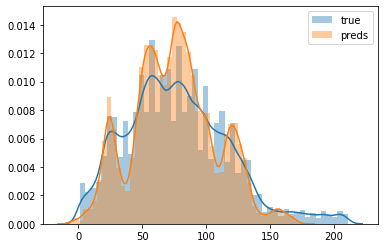

In [0]:
sns.distplot(y_test, label = 'true')
sns.distplot(predictions, label = 'preds')
plt.legend()